In [2]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from networkx.algorithms import community

Load the dataset and do exploration

In [3]:
G = pickle.load(open('../data/ex_1_graph.pickle', 'rb'))

### Dataset Exploration
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Is directed: {G.is_directed()}")
print(f"Graph density: {nx.density(G):.2f}")

print("\n")

# List all unique node attribute keys
all_node_attrs = set()
for node in G.nodes():
    all_node_attrs.update(G.nodes[node].keys())
print(f"All available node attributes: {sorted(all_node_attrs)}")

# List all unique edge attribute keys
all_edge_attrs = set()
for u, v in G.edges():
    all_edge_attrs.update(G.edges[u, v].keys())
print(f"All available edge attributes: {sorted(all_edge_attrs)}")

print("\n")

# Example: first node and all its at tributes
first_node = list(G.nodes())[0]
print(f"Example node: {first_node}")
print(f"Node attributes: {G.nodes[first_node]}")

# Example: first edge and all its attributes
first_edge = list(G.edges())[0]
print(f"Example edge: {first_edge}")
print(f"Edge attributes: {G.edges[first_edge]}")

print("\n")

print(f"Graph attributes: {dict(G.graph)}")

degrees = [G.degree(n) for n in G.nodes()]
print(f"Degree - Min: {min(degrees)}, Max: {max(degrees)}, Mean: {np.mean(degrees):.2f}")
if nx.is_connected(G):
    print(f"Avg shortest path: {nx.average_shortest_path_length(G):.2f}")


Number of nodes: 60
Number of edges: 498
Is directed: False
Graph density: 0.28


All available node attributes: ['faction', 'name']
All available edge attributes: ['messages']


Example node: 0
Node attributes: {'name': 'Eric Hill', 'faction': 'A'}
Example edge: (0, 1)
Edge attributes: {'messages': 21}


Graph attributes: {}
Degree - Min: 10, Max: 24, Mean: 16.60
Avg shortest path: 1.77


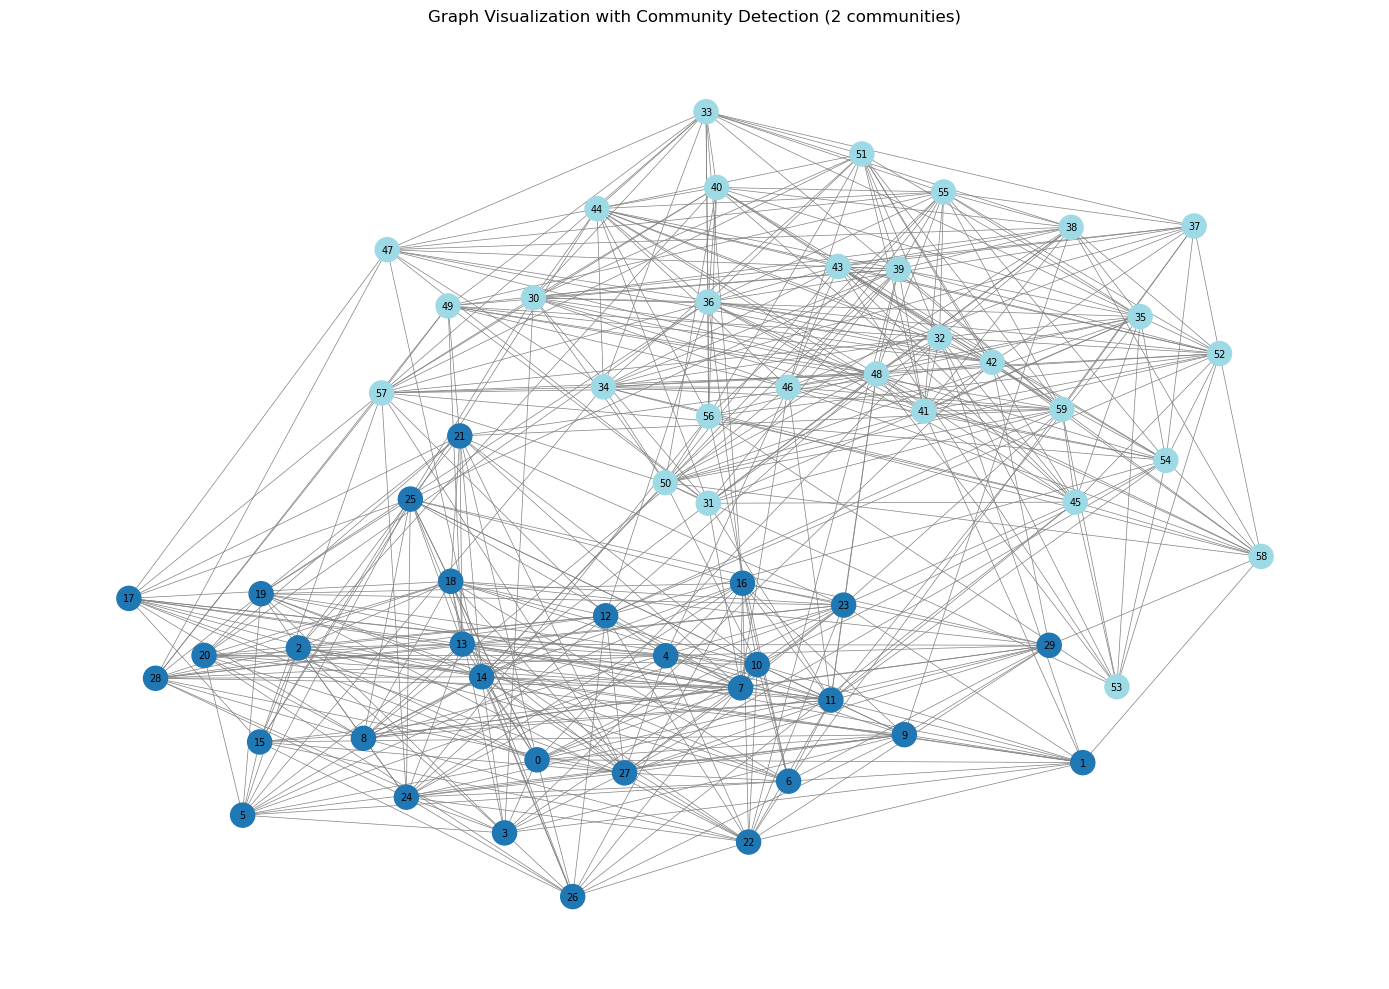

In [4]:
communities = list(community.greedy_modularity_communities(G, weight='messages'))
color_map = [0] * len(G)
for i, comm in enumerate(communities):
    for node in comm:
        color_map[node] = i

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=1, iterations=50)
nx.draw_networkx(G, pos, node_color=color_map, cmap='tab20', 
                 node_size=300, with_labels=True, font_size=7, edge_color='gray', width=0.5)
plt.title(f"Graph Visualization with Community Detection ({len(communities)} communities)")
plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
# Prepare edge data with message weights
edges = np.array(list(G.edges()))
nodes_list = list(G.nodes())
node_to_idx = {node: idx for idx, node in enumerate(nodes_list)}

# Convert edges to indices and extract message counts
edge_indices = np.array([[node_to_idx[u], node_to_idx[v]] for u, v in edges])
edge_messages = np.array([G.edges[u, v]['messages'] for u, v in edges])

n_nodes = len(nodes_list)

# Prepare faction and weighted degree data for visualization
factions = {}
for node in G.nodes():
    factions[node] = G.nodes[node]['faction']

weighted_degree = {node: sum(G[node][neighbor]['messages'] for neighbor in G[node]) for node in G.nodes()}

## Weighted Bayesian Latent Space Model

The model uses **message counts** as a Poisson distribution.

**Model**: `messages_ij ~ Poisson(λ = exp(α - β * ||z_i - z_j||))`

Where:
- `z_i, z_j` are latent positions of nodes i and j
- `α` is a global intercept (baseline communication rate)
- `β` used as prior

In [6]:
latent_dim = 2

with pm.Model() as model:
    z = pm.Normal('z', mu=0, sigma=1.0, shape=(n_nodes, latent_dim))
    
    alpha = pm.Normal('alpha', mu=np.log(edge_messages.mean()), sigma=1.0)
    beta = pm.HalfNormal('beta', sigma=1.0)
    
    # Euclidean distances for all observed edges
    # Shape of z below: (num_edges, latent_dim)
    z_i = z[edge_indices[:, 0]]
    z_j = z[edge_indices[:, 1]]
    distances = pm.math.sqrt(pm.math.sum((z_i - z_j)**2, axis=1))
    
    # Log-link: lambda = exp(alpha - beta * distance)
    # Smaller distance (closer in latent space) = more messages
    # beta scales the effect of distance
    log_lambda = alpha - beta * distances
    
    # Likelihood
    messages_obs = pm.Poisson('messages_obs', mu=pm.math.exp(log_lambda), observed=edge_messages)
    trace = pm.sample(
        draws=7500,
        tune=3000,
        cores=6,
        chains=6,
        random_seed=42,
        progressbar=True,
        return_inferencedata=True,
        target_accept=0.95
    )
print("Convergence Summary:")
summary = az.summary(trace, var_names=['z', 'alpha', 'beta'])
print(summary.head(15))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [z, alpha, beta]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [z, alpha, beta]


Output()

Sampling 6 chains for 3_000 tune and 7_500 draw iterations (18_000 + 45_000 draws total) took 175 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Convergence Summary:
          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
z[0, 0] -0.001  0.981  -1.505    1.491      0.059    0.010     320.0   
z[0, 1]  0.072  0.971  -1.468    1.523      0.044    0.010     526.0   
z[1, 0]  0.005  1.037  -1.585    1.621      0.063    0.010     308.0   
z[1, 1]  0.074  1.035  -1.568    1.633      0.047    0.010     519.0   
z[2, 0] -0.009  1.034  -1.648    1.656      0.058    0.011     361.0   
z[2, 1]  0.071  1.013  -1.590    1.694      0.045    0.010     557.0   
z[3, 0] -0.007  0.821  -1.324    1.323      0.045    0.008     378.0   
z[3, 1]  0.057  0.809  -1.266    1.347      0.034    0.008     601.0   
z[4, 0]  0.011  0.987  -1.531    1.521      0.059    0.010     304.0   
z[4, 1]  0.070  0.996  -1.515    1.556      0.047    0.010     488.0   
z[5, 0] -0.007  0.736  -1.259    1.185      0.039    0.006     409.0   
z[5, 1]  0.047  0.727  -1.185    1.233      0.029    0.006     663.0   
z[6, 0]  0.004  1.055  -1.600    1.594     

Learned embeddings shape: (60, 2)
Embedding statistics:
  Mean: -0.0012
  Std: 0.0518
Ranges for Dimensions in R^2 latent space
  Dimension 1 range: [-0.01, 0.02]
  Dimension 2 range: [-0.09, 0.09]


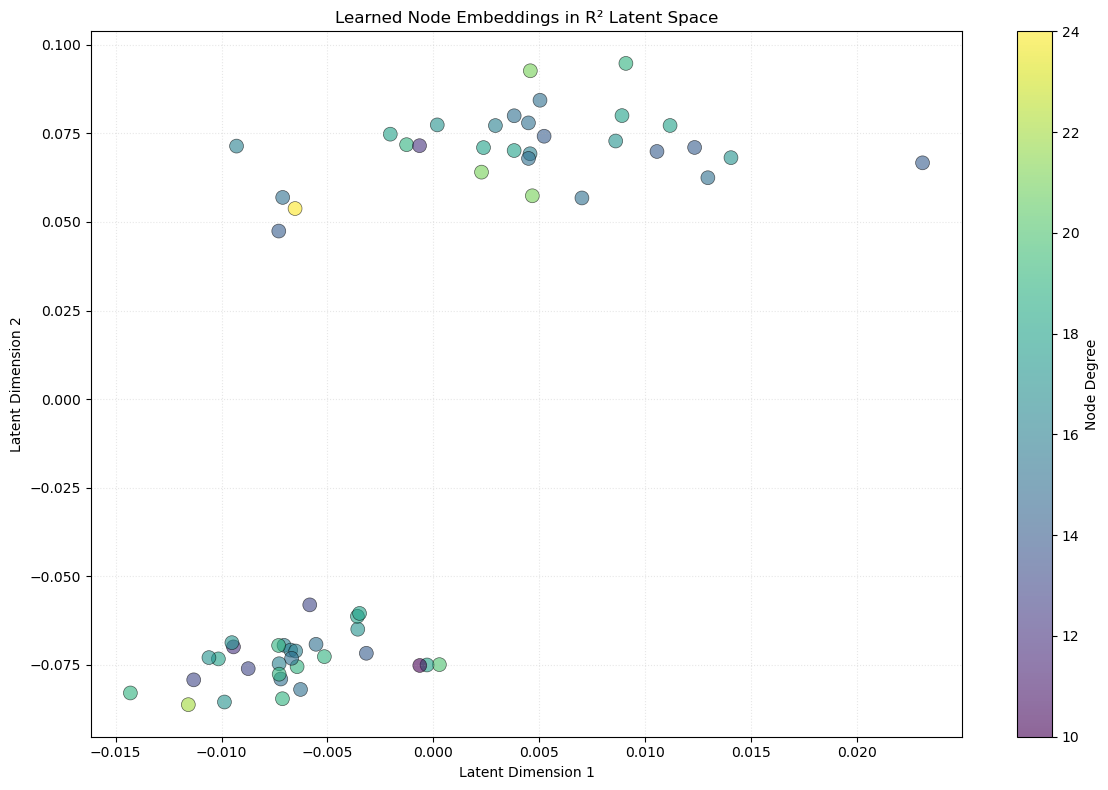

In [15]:
# Extract the learned embeddings using az.extract
# az.extract combines chains and draws into a single 'sample' dimension
# Returns xarray with shape: (n_nodes, latent_dim, n_samples)
z_extract = az.extract(trace, group="posterior", var_names=["z"])

# Calculate the mean across the 'sample' dimension to get (n_nodes, latent_dim)
z_posterior = z_extract.mean(dim="sample").values

print(f"Learned embeddings shape: {z_posterior.shape}")
print(f"Embedding statistics:\n  Mean: {z_posterior.mean():.4f}\n  Std: {z_posterior.std():.4f}")

z_2d = z_posterior

print(f"Ranges for Dimensions in R^{latent_dim} latent space")
print(f"  Dimension 1 range: [{z_2d[:, 0].min():.2f}, {z_2d[:, 0].max():.2f}]")
print(f"  Dimension 2 range: [{z_2d[:, 1].min():.2f}, {z_2d[:, 1].max():.2f}]")

# Visualize learned embeddings in native latent space
plt.figure(figsize=(12, 8))
scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=degrees, s=100,
                     cmap='viridis', alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Node Degree')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Learned Node Embeddings in R² Latent Space')
plt.grid(alpha=0.3, linestyle=':')
plt.tight_layout()
plt.show()

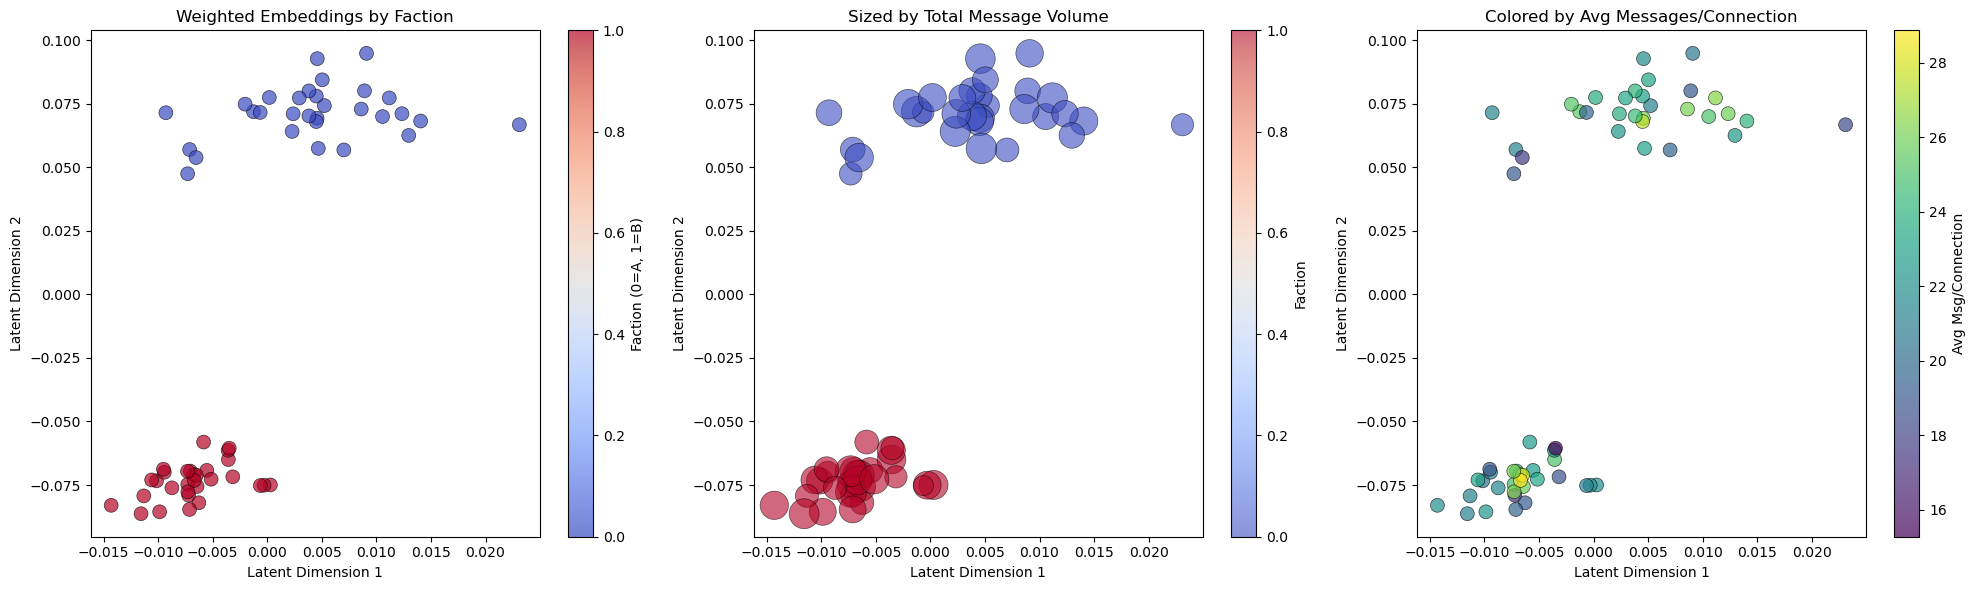

In [16]:
# Calculate average message volume for each node
node_avg_messages = {}
for node in G.nodes():
    total_msgs = sum(G[node][neighbor]['messages'] for neighbor in G[node])
    node_avg_messages[node] = total_msgs / G.degree(node)

# Create visualization comparing embeddings with actual message patterns
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Embeddings colored by faction
ax = axes[0]
node_factions = [factions[nodes_list[i]] for i in range(len(nodes_list))]
faction_colors = [0 if f == 'A' else 1 for f in node_factions]
scatter1 = ax.scatter(z_2d[:, 0], z_2d[:, 1], c=faction_colors, s=100, 
                      cmap='coolwarm', alpha=0.7, edgecolors='black', linewidth=0.5)
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_title('Weighted Embeddings by Faction')
plt.colorbar(scatter1, ax=ax, label='Faction (0=A, 1=B)')

# Plot 2: Embeddings sized by total message volume
ax = axes[1]
total_messages_per_node = [weighted_degree[nodes_list[i]] for i in range(len(nodes_list))]
scatter2 = ax.scatter(z_2d[:, 0], z_2d[:, 1], c=faction_colors, 
                      s=np.array(total_messages_per_node), 
                      cmap='coolwarm', alpha=0.6, edgecolors='black', linewidth=0.5)
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_title('Sized by Total Message Volume')
plt.colorbar(scatter2, ax=ax, label='Faction')

# Plot 3: Embeddings colored by average messages per connection
ax = axes[2]
avg_msgs_per_node = [node_avg_messages[nodes_list[i]] for i in range(len(nodes_list))]
scatter3 = ax.scatter(z_2d[:, 0], z_2d[:, 1], c=avg_msgs_per_node, s=100, 
                      cmap='viridis', alpha=0.7, edgecolors='black', linewidth=0.5)
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_title('Colored by Avg Messages/Connection')
plt.colorbar(scatter3, ax=ax, label='Avg Msg/Connection')

plt.tight_layout()
plt.show()


## Model Validation

In [26]:
# Calculate pairwise distances in latent space for all edges
latent_distances = []
actual_messages = []

for u, v in G.edges():
    u_idx = node_to_idx[u]
    v_idx = node_to_idx[v]
    
    # Euclidean distance in latent space
    dist = np.linalg.norm(z_posterior[u_idx] - z_posterior[v_idx])
    latent_distances.append(dist)
    actual_messages.append(G.edges[u, v]['messages'])

latent_distances = np.array(latent_distances)
actual_messages = np.array(actual_messages)

# Generate posterior predictive samples using PyMC
with model:
    ppc = pm.sample_posterior_predictive(trace, random_seed=42)

# Extract posterior predictive samples
predicted_messages_samples = az.extract(
    ppc,
    group="posterior_predictive",
    var_names=["messages_obs"]
).values
# az.extract returns shape (n_edges, n_samples)
# We want (n_samples, n_edges) for calculation
predicted_messages_samples = predicted_messages_samples.T

n_samples, n_edges = predicted_messages_samples.shape
# Reshape from (chains, draws, edges) to (samples, edges)

# Compute posterior predictive mean and credible intervals
predicted_mean = predicted_messages_samples.mean(axis=0)
predicted_lower = np.percentile(predicted_messages_samples, 2.5, axis=0)
predicted_upper = np.percentile(predicted_messages_samples, 97.5, axis=0)

# Calculate metrics
pearson_corr, p_value = pearsonr(-latent_distances, actual_messages)
spearman_corr, sp_pvalue = spearmanr(-latent_distances, actual_messages)

coverage = np.mean((actual_messages >= predicted_lower) & (actual_messages <= predicted_upper))

ss_res = np.sum((actual_messages - predicted_mean) ** 2)
ss_tot = np.sum((actual_messages - actual_messages.mean()) ** 2)
r_squared = 1 - (ss_res / ss_tot)

n_data = len(actual_messages)
n_params = n_nodes * latent_dim + 2
r_squared_adj = 1 - (1 - r_squared) * (n_data - 1) / (n_data - n_params - 1)

# Print raw values
print(f"pearson_corr = {pearson_corr}")
print(f"p_value = {p_value}")
print(f"spearman_corr = {spearman_corr}")
print(f"sp_pvalue = {sp_pvalue}")
print(f"coverage = {coverage}")
print(f"r_squared = {r_squared}")
print(f"r_squared_adj = {r_squared_adj}")

Sampling: [messages_obs]


Output()

pearson_corr = 0.8196541200967675
p_value = 4.280575528668114e-122
spearman_corr = 0.6348397194958578
sp_pvalue = 1.5409715615951955e-57
coverage = 0.9959839357429718
r_squared = 0.8462366127820342
r_squared_adj = 0.7962122574737893


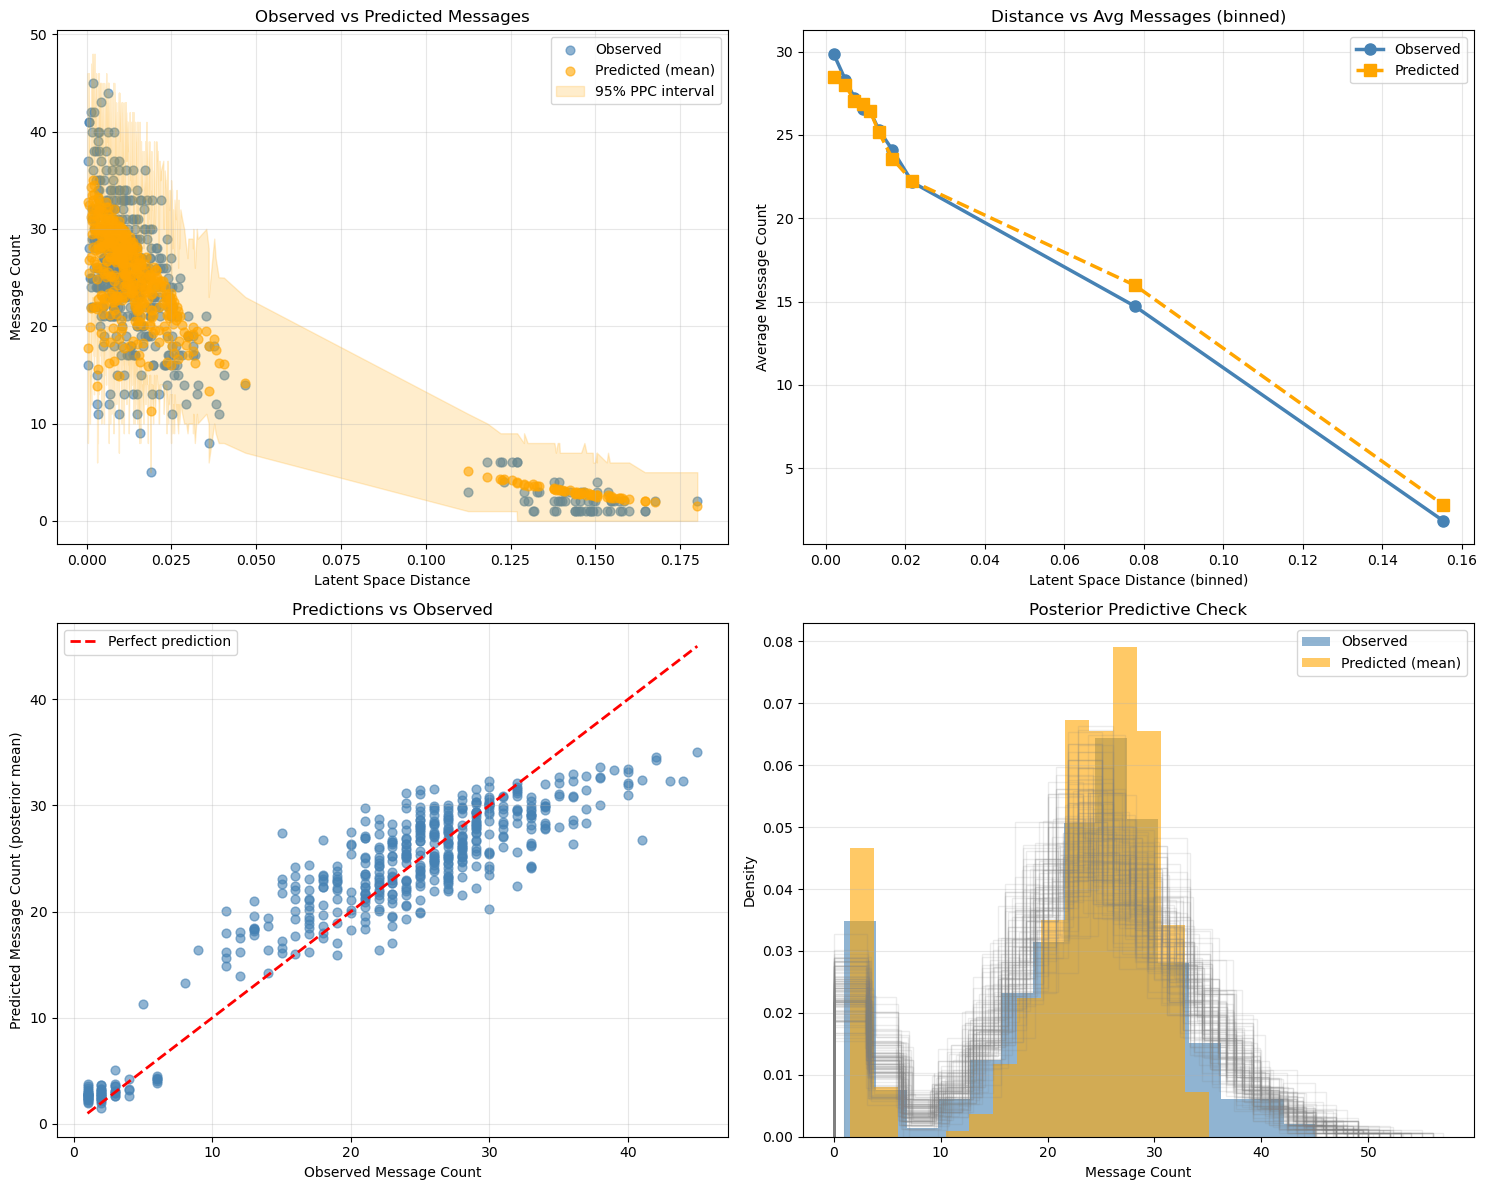

In [27]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

ax = axes[0, 0]
ax.scatter(latent_distances, actual_messages, alpha=0.6, s=40, label='Observed', color='steelblue')
ax.scatter(latent_distances, predicted_mean, alpha=0.6, s=40, label='Predicted (mean)', color='orange')
ax.fill_between(np.sort(latent_distances), 
                predicted_lower[np.argsort(latent_distances)], 
                predicted_upper[np.argsort(latent_distances)], 
                alpha=0.2, color='orange', label='95% PPC interval')
ax.set_xlabel('Latent Space Distance')
ax.set_ylabel('Message Count')
ax.set_title('Observed vs Predicted Messages')
ax.legend()
ax.grid(alpha=0.3)

ax = axes[0, 1]
n_bins = 10
bin_edges = np.percentile(latent_distances, np.linspace(0, 100, n_bins + 1))
bin_centers = []
bin_means_obs = []
bin_means_pred = []
for i in range(n_bins):
    mask = (latent_distances >= bin_edges[i]) & (latent_distances < bin_edges[i+1])
    if mask.sum() > 0:
        bin_centers.append((bin_edges[i] + bin_edges[i+1]) / 2)
        bin_means_obs.append(actual_messages[mask].mean())
        bin_means_pred.append(predicted_mean[mask].mean())

ax.plot(bin_centers, bin_means_obs, 'o-', linewidth=2.5, markersize=8, label='Observed', color='steelblue')
ax.plot(bin_centers, bin_means_pred, 's--', linewidth=2.5, markersize=8, label='Predicted', color='orange')
ax.set_xlabel('Latent Space Distance (binned)')
ax.set_ylabel('Average Message Count')
ax.set_title('Distance vs Avg Messages (binned)')
ax.legend()
ax.grid(alpha=0.3)

ax = axes[1, 0]
ax.scatter(actual_messages, predicted_mean, alpha=0.6, s=40, color='steelblue')
min_val = min(actual_messages.min(), predicted_mean.min())
max_val = max(actual_messages.max(), predicted_mean.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
ax.set_xlabel('Observed Message Count')
ax.set_ylabel('Predicted Message Count (posterior mean)')
ax.set_title('Predictions vs Observed')
ax.legend()
ax.grid(alpha=0.3)

ax = axes[1, 1]
# Plot posterior predictive samples first (in background)
for i in range(min(100, n_samples)):
    ax.hist(predicted_messages_samples[i], bins=15, alpha=0.15, color='gray', density=True, histtype='step')

# Plot observed and predicted mean on top
ax.hist(actual_messages, bins=15, alpha=0.6, label='Observed', color='steelblue', density=True)
ax.hist(predicted_mean, bins=15, alpha=0.6, label='Predicted (mean)', color='orange', density=True)

ax.set_xlabel('Message Count')
ax.set_ylabel('Density')
ax.set_title('Posterior Predictive Check')
ax.legend()
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Correlation metrics:
The Pearson correlation coefficient shows strong linear relationship and the latent space is representative, i.e. the closer the nodes get to one another, the more messages are there.
The Spearman correlation coefficient shows good monotonic relationship, showing consistency in distance influencing messages.
Finally, the above p value is extremely low, meaning that the correlations are extremely statistically significant.

### Goodness of fit and Validation:
Given an R^2 of ~.85 and an Adj. R^2 of ~.80 shows that the model can explain the variance quite well given the confidence interval of 95%, with the coverage of 99.5%.

## Exercise 1: Answering Q1 and Q2

**Q1: Who is the most influential politician from each faction?**

**Q2: Who are the two politicians best suited for inter-faction negotiations?**


In [35]:
# Q1: Most Influential Politician from Each Faction
# Using composite score: network metrics + embedding space position

degree_centrality = nx.degree_centrality(G)
max_weighted_degree = max(weighted_degree.values())
weighted_degree_centrality = {node: weighted_degree[node] / max_weighted_degree for node in G.nodes()}
betweenness_centrality = nx.betweenness_centrality(G, weight='messages')
closeness_centrality = nx.closeness_centrality(G, distance='messages')
eig_centrality = nx.eigenvector_centrality_numpy(G, weight='messages')

# Normalize all metrics to [0, 1] for combining
max_betweenness = max(betweenness_centrality.values())
max_closeness = max(closeness_centrality.values())
max_eigenvector = max(eig_centrality.values())

betweenness_norm = {node: betweenness_centrality[node] / max_betweenness for node in G.nodes()}
closeness_norm = {node: closeness_centrality[node] / max_closeness for node in G.nodes()}
eigenvector_norm = {node: eig_centrality[node] / max_eigenvector for node in G.nodes()}

print("Analyzing each faction with composite influence score:")
print("  Composite = 25% Degree + 25% Weighted Degree + 20% Betweenness + 15% Closeness + 15% Eigenvector\n")

for faction in ['A', 'B']:
    print(f"From Faction {faction}")
    
    faction_nodes = [n for n in G.nodes() if factions[n] == faction]
    faction_indices = [node_to_idx[n] for n in faction_nodes]
    faction_embeddings = z_posterior[faction_indices]
    
    # Compute faction centroid in embedding space
    faction_centroid = faction_embeddings.mean(axis=0)
    distances_to_centroid = np.linalg.norm(faction_embeddings - faction_centroid, axis=1)
    max_dist = distances_to_centroid.max() if distances_to_centroid.max() > 0 else 1.0
    
    # Build comprehensive influence table
    faction_influence = []
    for idx, node in enumerate(faction_nodes):
        # Embedding position score (closeness to faction center)
        dist_to_center = distances_to_centroid[idx]
        centrality_score = 1 - (dist_to_center / max_dist)  # 1 = at center, 0 = at edge
        
        # Composite network influence score
        composite_score = (
            0.25 * degree_centrality[node] +
            0.25 * weighted_degree_centrality[node] +
            0.20 * betweenness_norm[node] +
            0.15 * closeness_norm[node] +
            0.15 * eigenvector_norm[node]
        )
        
        faction_influence.append({
            'Node': node,
            'Degree': G.degree(node),
            'Total Messages': weighted_degree[node],
            'Composite Score': composite_score,
            'Degree Cent.': degree_centrality[node],
            'Weighted Deg.': weighted_degree_centrality[node],
            'Betweenness': betweenness_centrality[node],
            'Closeness': closeness_centrality[node],
            'Eigenvector': eig_centrality[node],
            'Embed. Centrality': centrality_score,
        })
    
    faction_df = pd.DataFrame(faction_influence).sort_values('Composite Score', ascending=False)
    
    # Display top influencer
    top_influencer = faction_df.iloc[0]
    print(f"Most influential node {top_influencer['Node']:.0f}")
    print(f"   Composite Influence Score: {top_influencer['Composite Score']:.3f}")
    print(f"   Network Metrics:")
    print(f"     - Degree: {top_influencer['Degree']:.0f} connections")
    print(f"     - Total Messages: {top_influencer['Total Messages']:.0f}")
    print(f"     - Betweenness: {top_influencer['Betweenness']:.3f}")
    print(f"     - Eigenvector: {top_influencer['Eigenvector']:.3f}")
    print(f"   Embedding Position: {top_influencer['Embed. Centrality']:.3f} (distance to faction center)")

Analyzing each faction with composite influence score:
  Composite = 25% Degree + 25% Weighted Degree + 20% Betweenness + 15% Closeness + 15% Eigenvector

From Faction A
Most influential node 12
   Composite Influence Score: 0.708
   Network Metrics:
     - Degree: 18 connections
     - Total Messages: 342
     - Betweenness: 0.420
     - Eigenvector: 0.136
   Embedding Position: 0.619 (distance to faction center)
From Faction B
Most influential node 48
   Composite Influence Score: 0.636
   Network Metrics:
     - Degree: 22 connections
     - Total Messages: 464
     - Betweenness: 0.167
     - Eigenvector: 0.121
   Embedding Position: 0.122 (distance to faction center)


In [29]:
# Q2: Politicians Best Suited for Inter-Faction Negotiations
# Using composite score: network metrics + embedding space analysis

# Calculate inter-faction connections with message weights
inter_faction_edges = []
inter_faction_messages = {node: 0 for node in G.nodes()}
for u, v in G.edges():
    if factions[u] != factions[v]:
        inter_faction_edges.append((u, v))
        messages = G.edges[u, v]['messages']
        inter_faction_messages[u] += messages
        inter_faction_messages[v] += messages

# Count inter-faction connections per node
inter_faction_count = {node: 0 for node in G.nodes()}
for u, v in inter_faction_edges:
    inter_faction_count[u] += 1
    inter_faction_count[v] += 1

# Calculate inter-faction ratio
inter_faction_ratio = {}
for node in G.nodes():
    total_degree = G.degree(node)
    if total_degree > 0:
        inter_faction_ratio[node] = inter_faction_count[node] / total_degree
    else:
        inter_faction_ratio[node] = 0

# Compute faction centroids in embedding space
A_centroid = z_posterior[[node_to_idx[n] for n in G.nodes() if factions[n] == 'A']].mean(axis=0)
B_centroid = z_posterior[[node_to_idx[n] for n in G.nodes() if factions[n] == 'B']].mean(axis=0)

# Find bridge candidates
bridge_candidates = []
for node in G.nodes():
    if inter_faction_count[node] > 0:
        # Embedding space analysis
        node_idx = node_to_idx[node]
        embedding = z_posterior[node_idx]
        dist_to_A = np.linalg.norm(embedding - A_centroid)
        dist_to_B = np.linalg.norm(embedding - B_centroid)
        
        # Balance score: 0 = perfectly centered, 1 = strongly aligned
        balance_score = abs(dist_to_A - dist_to_B) / (dist_to_A + dist_to_B)
        
        # Normalize metrics for composite scoring
        bridge_candidates.append({
            'node': node,
            'faction': factions[node],
            'inter_faction_connections': inter_faction_count[node],
            'inter_faction_messages': inter_faction_messages[node],
            'total_degree': G.degree(node),
            'total_messages': weighted_degree[node],
            'inter_faction_ratio': inter_faction_ratio[node],
            'inter_faction_msg_ratio': inter_faction_messages[node] / weighted_degree[node] if weighted_degree[node] > 0 else 0,
            'betweenness': betweenness_centrality[node],
            'dist_to_A': dist_to_A,
            'dist_to_B': dist_to_B,
            'balance_score': balance_score,
        })

bridge_df = pd.DataFrame(bridge_candidates)

# Normalize metrics for composite scoring
max_connections = bridge_df['inter_faction_connections'].max()
max_betweenness_bridge = bridge_df['betweenness'].max()
max_messages = bridge_df['inter_faction_messages'].max()

connections_norm = bridge_df['inter_faction_connections'] / max_connections
betweenness_norm_bridge = bridge_df['betweenness'] / max_betweenness_bridge
messages_norm = bridge_df['inter_faction_messages'] / max_messages
balance_norm = 1 - bridge_df['balance_score']  # Invert so higher balance = higher score

# Composite bridge score: 25% Connections + 20% Betweenness + 40% Message Volume + 15% Balance
bridge_df['bridge_score'] = (
    0.25 * connections_norm +
    0.20 * betweenness_norm_bridge +
    0.40 * messages_norm +
    0.15 * balance_norm
)

top_bridges = bridge_df.nlargest(5, 'bridge_score')

print("\nAnalyzing with composite score:")
print("  Composite = 25% Inter-faction Connections + 20% Betweenness +")
print("              40% Inter-faction Message Volume + 15% Balance Score\n")

for i, (idx, row) in enumerate(top_bridges.head(2).iterrows(), 1):
    node = row['node']
    print(f"Faction {row['faction']} - Node {node}")
    print(f"   Bridge Score: {row['bridge_score']:.3f}")
    print(f"   Network Metrics:")
    print(f"     - Inter-faction connections: {row['inter_faction_connections']} out of {row['total_degree']} total")
    print(f"     - Inter-faction messages: {row['inter_faction_messages']:.0f} ({row['inter_faction_msg_ratio']:.1%} of communication)")
    print(f"     - Betweenness centrality: {row['betweenness']:.3f}")
    print(f"   Embedding Space Analysis:")
    print(f"     - Distance to Faction A centroid: {row['dist_to_A']:.3f}")
    print(f"     - Distance to Faction B centroid: {row['dist_to_B']:.3f}")
    print(f"     - Balance Score: {row['balance_score']:.3f}")


Analyzing with composite score:
  Composite = 25% Inter-faction Connections + 20% Betweenness +
              40% Inter-faction Message Volume + 15% Balance Score

Faction B - Node 57
   Bridge Score: 0.790
   Network Metrics:
     - Inter-faction connections: 6 out of 18 total
     - Inter-faction messages: 18 (6.5% of communication)
     - Betweenness centrality: 0.388
   Embedding Space Analysis:
     - Distance to Faction A centroid: 0.132
     - Distance to Faction B centroid: 0.013
     - Balance Score: 0.815
Faction A - Node 11
   Bridge Score: 0.765
   Network Metrics:
     - Inter-faction connections: 6 out of 24 total
     - Inter-faction messages: 22 (5.2% of communication)
     - Betweenness centrality: 0.154
   Embedding Space Analysis:
     - Distance to Faction A centroid: 0.020
     - Distance to Faction B centroid: 0.127
     - Balance Score: 0.724


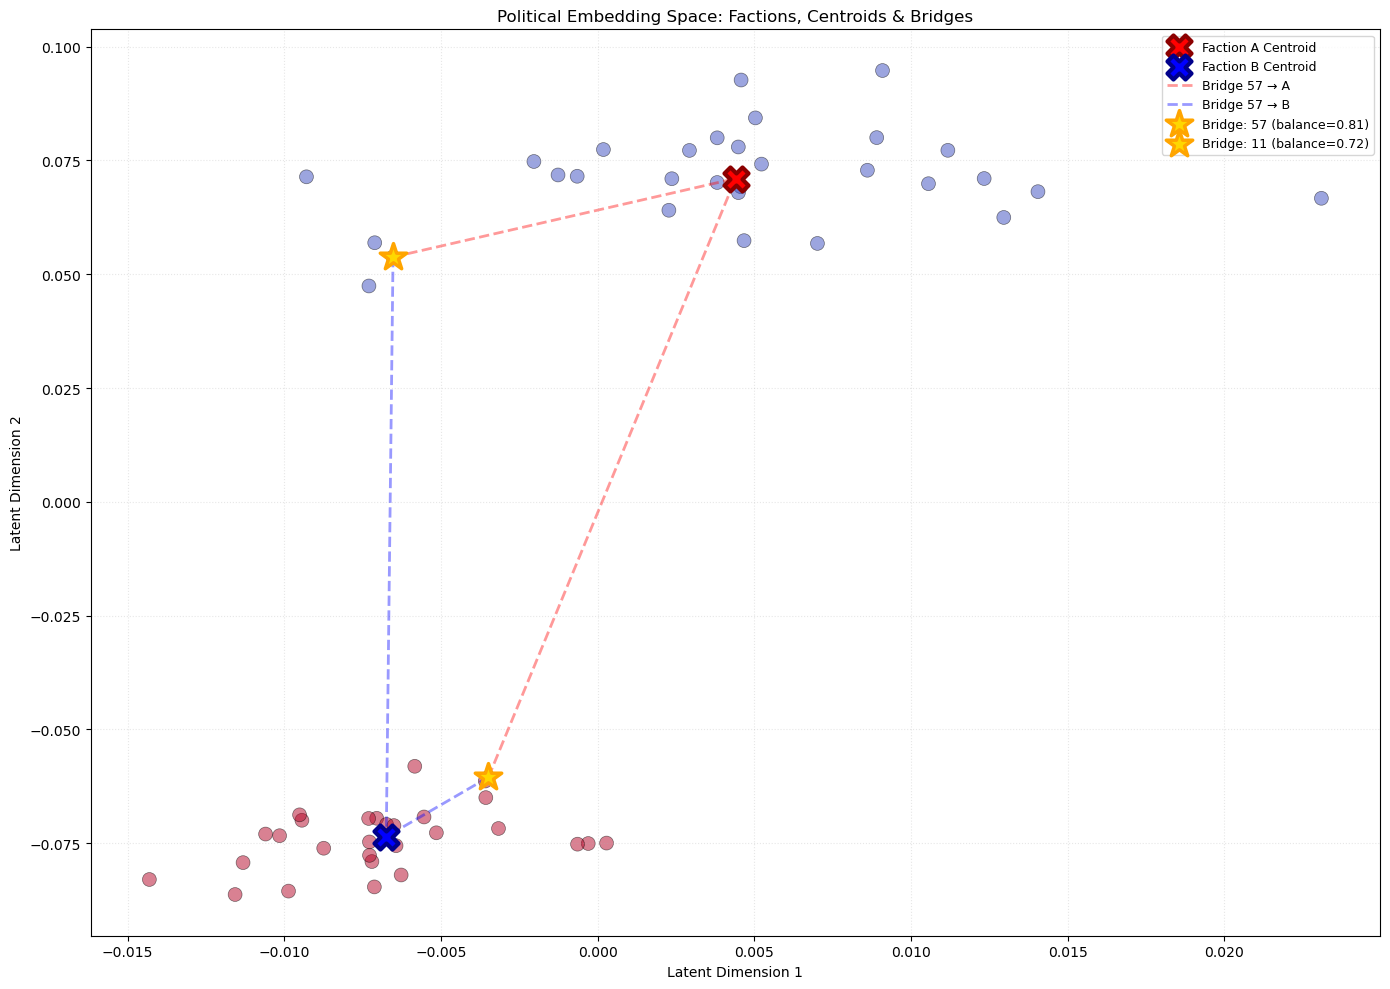

In [38]:
# Centroids are already in the same latent space (R^2) - no transformation needed
A_cent_2d = A_centroid  # Already 2D
B_cent_2d = B_centroid  # Already 2D

fig, ax = plt.subplots(figsize=(14, 10))

# Plot all nodes colored by faction
scatter = ax.scatter(z_2d[:, 0], z_2d[:, 1], c=faction_colors, s=100, 
                     cmap='coolwarm', alpha=0.5, edgecolors='black', linewidth=0.5)

# Plot faction centroids as large markers
ax.scatter(*A_cent_2d, s=300, marker='X', c='red', edgecolors='darkred', linewidth=3, 
          label='Faction A Centroid', zorder=5)
ax.scatter(*B_cent_2d, s=300, marker='X', c='blue', edgecolors='darkblue', linewidth=3, 
          label='Faction B Centroid', zorder=5)

# Draw lines from top 2 bridges to both centroids (showing "pull" of each faction)
for idx, row in top_bridges.head(2).iterrows():
    node = row['node']
    node_idx = node_to_idx[node]
    node_2d = z_2d[node_idx]
    
    # Line to Faction A centroid (red dashed)
    ax.plot([node_2d[0], A_cent_2d[0]], [node_2d[1], A_cent_2d[1]], 
            'r--', alpha=0.4, linewidth=2, label=f"Bridge {node} → A" if idx == top_bridges.index[0] else "")
    
    # Line to Faction B centroid (blue dashed)
    ax.plot([node_2d[0], B_cent_2d[0]], [node_2d[1], B_cent_2d[1]], 
            'b--', alpha=0.4, linewidth=2, label=f"Bridge {node} → B" if idx == top_bridges.index[0] else "")
    
    # Highlight bridge politician
    ax.scatter(*node_2d, s=400, marker='*', c='gold', edgecolors='orange', linewidth=2.5, 
              label=f"Bridge: {node} (balance={row['balance_score']:.2f})", zorder=4)

ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_title('Political Embedding Space: Factions, Centroids & Bridges')
ax.legend(loc='best', fontsize=9)
ax.grid(alpha=0.3, linestyle=':')
plt.tight_layout()
plt.show()


In [ ]:
# Bonus: What happens if factions are completely separated?

# Create subgraphs for each faction
faction_A_nodes = [n for n in G.nodes() if factions[n] == 'A']
faction_B_nodes = [n for n in G.nodes() if factions[n] == 'B']

# Create subgraphs for each faction
faction_A_subgraph = G.subgraph(faction_A_nodes).copy()
faction_B_subgraph = G.subgraph(faction_B_nodes).copy()

# Remove inter-faction edges for comparison
G_separated = G.copy()
edges_to_remove = [(u, v) for u, v in G.edges() if factions[u] != factions[v]]
G_separated.remove_edges_from(edges_to_remove)

print("\nOriginal network:")
print(f"  Total edges: {G.number_of_edges()}")
print(f"  Inter-faction edges: {len(inter_faction_edges)}")
print(f"  Intra-faction edges: {G.number_of_edges() - len(inter_faction_edges)}")

print("\nSeparated network (without inter-faction edges):")
print(f"  Total edges: {G_separated.number_of_edges()}")
print(f"  Edge reduction: {len(inter_faction_edges)} edges ({100*len(inter_faction_edges)/G.number_of_edges():.1f}%)")

num_components = nx.number_connected_components(G_separated)
print(f"  Network breaks into {num_components} disconnected components")

for comp_idx, component in enumerate(nx.connected_components(G_separated)):
    comp_size = len(component)
    comp_factions = set([factions[n] for n in component])
    print(f"    Component {comp_idx+1}: {comp_size} nodes from faction {comp_factions}")

# Compare network metrics
print("\nNetwork density comparison:")
print(f"  Original: {nx.density(G):.2f}")
print(f"  Separated: {nx.density(G_separated):.2f}")

print("\nAverage degree comparison:")
original_avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
separated_avg_degree = sum(dict(G_separated.degree()).values()) / G_separated.number_of_nodes()
print(f"  Original: {original_avg_degree:.2f}")
print(f"  Separated: {separated_avg_degree:.2f}")



Original network:
  Total edges: 498
  Inter-faction edges: 61
  Intra-faction edges: 437

Separated network (without inter-faction edges):
  Total edges: 437
  Edge reduction: 61 edges (12.2%)
  Network breaks into 2 disconnected components
    Component 1: 30 nodes from faction {'A'}
    Component 2: 30 nodes from faction {'B'}

Network density comparison:
  Original: 0.28
  Separated: 0.25

Average degree comparison:
  Original: 16.60
  Separated: 14.57
The inter-faction connections represent ~12.2% of the network's edges.
The bridge politicians identified in Q2 are crucial for maintaining overall network connectivity.


The inter-faction connections represent ~12.2% of the network's edges.
The bridge politicians identified in Q2 are crucial for maintaining overall network connectivity. Otherwise, the network density or the average degree does not change much, so the two factions are relatively independent.